# LDA 

In [1]:
import pandas as pd
import numpy as np
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
import nltk
from nrclex import NRCLex
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
from operator import itemgetter

%matplotlib inline
from matplotlib import pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import sys
import warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
def compute_coherence_values(dictionary, corpus, texts, limit=10, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def get_timed_data(df, col, start_date, end_date):
    
    def isEnglish(s): 
        try: s.encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError: return False
        else: return True

    df['clean_data'] = df['clean_data'].fillna('')
    df['language'] = df['clean_data'].apply(lambda x: isEnglish(x))
    df['date'] = pd.to_datetime(df[col])
    df = df[df['language'] == True]
    df = df.drop(columns=['Unnamed: 0','language'])
    timed_df = df.loc[(df['date'] >= start_date) & (df['date'] < end_date)]
    
    text_list = timed_df['clean_data'].to_list()
    
    return timed_df, text_list

def get_arguments(text_list, remove_list):
    texts = [[word for word in text.lower().split() 
              if word not in STOPWORDS and word.isalnum() and not word.isdigit() and word not in remove_list] 
             for text in text_list]

    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    return texts, dictionary, corpus

def get_score_graph(start=5, limit=15, step=2):
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, 
                                                            start=start, limit=limit, step=step)
    # Show graph
    limit=limit; start=start; step=step;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
def lda_graph(n):
    lda = LdaModel(corpus, id2word=dictionary, num_topics=n, passes=15, random_state=42)
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda, corpus, dictionary)
    return lda, vis

def get_topic(df):
    
    def topic(corpus):
        topic_list = []
        for i in range(len(corpus)):
            topic = sorted(lda.get_document_topics(corpus[i], minimum_probability=0, per_word_topics=False), key=itemgetter(1), reverse=True)[0][0]
            topic_list.append(topic)
        return topic_list
    
    df['topic'] = topic(corpus)
    
    def get_words(topic): return [i[0] for i in lda.show_topic(topic, topn=20)]
    df['topic_words'] = df['topic'].apply(lambda x: get_words(x))
    return df

### Time Period for Each Company (14 models)

<b>DIS:</b> 2010 - 6/2015, 6/2015 - 6/2017, 6/2017 - 6/2019, 6/2019 - 2021 => 4 models<br>
<b>AAL:</b> 2013 - 2015, 2015 - 2019, 2019 - 2020, 2020 - 2021 => 4 models<br>
<b>PEP:</b> 2010 - 6/2011, 6/2011 - 6/2013, 6/2013 - 6/2015, 6/2015 - 2018, 2018 - 2019, 2019 - 2021 => 6 models<br>

# Disney

In [3]:
dis = pd.read_pickle("./Data/dis_cnbc_senti.pkl")
dis.head(1)

,Unnamed: 0,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy
0,0,Disney raises price of ESPN+ by a dollar to $6...,7/12/2021 10:21:08 PM,Technology,https://www.cnbc.com/2021/07/12/disney-raises-...,"Disney raises price of ESPN+ by a dollar, keep...",disney raises price of espn+ by a dollar to ...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2010.1.1 - 2015.6.1

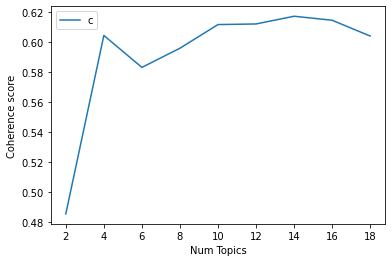

In [4]:
timed_df, text_list = get_timed_data(dis, 'Date', '2010-01-01', '2015-06-01')
remove_list = ['disney','walt','says','stock','s','p','u','m','q','th','vs']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=2, limit=20, step=2)

In [5]:
lda, vis = lda_graph(14)
lda.print_topics()

[(0,
  '0.038*"job" + 0.027*"search" + 0.023*"investors" + 0.015*"buffett" + 0.015*"cnbc" + 0.015*"market" + 0.014*"money" + 0.014*"quarter" + 0.012*"cablevision" + 0.012*"fast"'),
 (1,
  '0.035*"trading" + 0.031*"market" + 0.021*"ad" + 0.019*"economic" + 0.015*"right" + 0.013*"consumer" + 0.012*"buzz" + 0.012*"tiger" + 0.010*"mean" + 0.009*"friday"'),
 (2,
  '0.039*"movers" + 0.037*"early" + 0.026*"video" + 0.023*"dis" + 0.014*"watch" + 0.014*"wednesday" + 0.013*"games" + 0.013*"retail" + 0.013*"dreamworks" + 0.011*"success"'),
 (3,
  '0.132*"stocks" + 0.039*"dow" + 0.034*"end" + 0.023*"banks" + 0.022*"gains" + 0.021*"energy" + 0.018*"nasdaq" + 0.017*"big" + 0.016*"best" + 0.016*"fall"'),
 (4,
  '0.057*"week" + 0.050*"stocks" + 0.030*"futures" + 0.027*"amid" + 0.024*"rise" + 0.024*"consecutive" + 0.023*"post" + 0.021*"worst" + 0.019*"dollar" + 0.018*"year"'),
 (5,
  '0.025*"trade" + 0.023*"deal" + 0.017*"wall" + 0.016*"street" + 0.015*"options" + 0.015*"action" + 0.011*"traders" + 0.0

In [6]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.275945  0.036006       1        1  12.436142
11     0.284948 -0.008067       2        1  12.102975
9     -0.104881  0.149050       3        1   7.306270
2     -0.089898 -0.158275       4        1   6.922449
4      0.166333 -0.007693       5        1   6.873926
10     0.013666 -0.009363       6        1   6.739786
13    -0.041267 -0.088073       7        1   6.701224
7     -0.080609  0.068961       8        1   6.421580
5     -0.070936  0.051302       9        1   6.402368
12    -0.098741  0.072414      10        1   6.082139
6     -0.039334  0.111127      11        1   5.960701
8     -0.084786 -0.015302      12        1   5.447811
1     -0.084538 -0.043629      13        1   5.307656
0     -0.045901 -0.158458      14        1   5.294974, topic_info=          Term        Freq       Total Category  logprob  loglift
472     stocks  407.000000  407.000000  Default  30.0000  30.0000
843       week   69.000000   69.000000  Default  29.0000  29.0000
577        dow  118.000000  118.000000  Default  28.0000  28.0000
133      ahead   77.000000   77.000000  Default  27.0000  27.0000
83         end   65.000000   65.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
218     market    9.199290   43.265748  Topic14  -4.2124   1.3902
1549     signs    3.962571    8.011160  Topic14  -5.0546   2.2345
661      watch    6.890880   44.749417  Topic14  -4.5013   1.0675
275   business    4.046622   16.605722  Topic14  -5.0336   1.5265
472     stocks    5.688837  407.537715  Topic14  -4.6930  -1.3332

[633 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
924       4  0.919614      aapl
495      11  0.953240       abc
1335     12  0.859529   academy
402       9  0.980436    action
2383      8  0.776076  activity
...     ...       ...       ...
19        7  0.896721       yes
2889     11  0.969914    yields
76        3  0.405067   youtube
76       13  0.506334   youtube
2320      1  0.890664      zone

[785 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 12, 10, 3, 5, 11, 14, 8, 6, 13, 7, 9, 2, 1])

In [7]:
dis_1 = get_topic(timed_df)
dis_1.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
1735,"Bob Iger: Disney has great IP, doesn't need more",5/5/2015 4:14:47 PM,Media,https://www.cnbc.com/2015/05/05/bob-iger-disne...,Bob Iger will not rule out future acquisitions...,bob iger disney has great ip doesn't need more,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-05-05 16:14:47,12,"[drops, highest, pops, play, ceo, nfl, losers,..."


In [8]:
dis_1.to_pickle("./Data/dis_1001_1506.pkl")

### 2015.6.1 - 2017.6.1

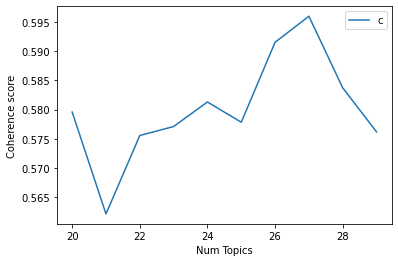

In [9]:
timed_df, text_list = get_timed_data(dis, 'Date', '2015-06-01', '2017-06-01')
remove_list = ['disney','walt','says','stock','s','p','u','m','q','th','vs','k','t','c']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=20, limit=30, step=1)

In [10]:
lda, vis = lda_graph(27)
lda.print_topics()

[(2,
  '0.058*"stocks" + 0.030*"close" + 0.016*"gains" + 0.016*"week" + 0.014*"lower" + 0.014*"growth" + 0.012*"media" + 0.012*"post" + 0.012*"best" + 0.010*"ceo"'),
 (16,
  '0.062*"dow" + 0.040*"stocks" + 0.022*"week" + 0.021*"trump" + 0.016*"ahead" + 0.016*"closes" + 0.012*"new" + 0.010*"amid" + 0.010*"lower" + 0.009*"trade"'),
 (5,
  '0.021*"stocks" + 0.018*"earnings" + 0.018*"falls" + 0.015*"street" + 0.013*"trump" + 0.013*"close" + 0.012*"traders" + 0.012*"ceo" + 0.010*"lower" + 0.010*"hasbro"'),
 (20,
  '0.027*"round" + 0.024*"lightning" + 0.023*"earnings" + 0.017*"media" + 0.010*"box" + 0.010*"disneyland" + 0.010*"build" + 0.007*"trades" + 0.007*"report" + 0.007*"office"'),
 (11,
  '0.065*"watch" + 0.042*"trade" + 0.035*"stocks" + 0.028*"earnings" + 0.017*"plan" + 0.015*"friday" + 0.015*"game" + 0.013*"february" + 0.013*"tuesday" + 0.012*"jobs"'),
 (10,
  '0.027*"ceo" + 0.024*"new" + 0.019*"netflix" + 0.017*"tv" + 0.014*"market" + 0.014*"hulu" + 0.011*"service" + 0.011*"dow" + 0

In [11]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.278120  0.200621       1        1  6.974369
15     0.084188  0.016468       2        1  5.379916
10     0.049948  0.008417       3        1  5.357669
16     0.129865  0.111421       4        1  4.823212
9      0.002722 -0.006534       5        1  4.678348
7     -0.023224 -0.022505       6        1  4.071074
2      0.110081  0.091814       7        1  4.055041
25     0.015987  0.102337       8        1  3.855720
1     -0.098417 -0.102892       9        1  3.785539
5      0.088577  0.020954      10        1  3.749515
23     0.022020 -0.037654      11        1  3.749251
11     0.081606 -0.030038      12        1  3.687687
12     0.072571  0.042491      13        1  3.576306
17     0.037376 -0.053807      14        1  3.437487
19    -0.060500  0.052849      15        1  3.436273
21    -0.037563 -0.040370      16        1  3.406468
3     -0.040100 -0.066492      17        1  3.249742
13    -0.029551 -0.072699      18        1  3.163998
0      0.054330  0.115199      19        1  3.052786
8     -0.004080  0.027969      20        1  3.041275
24    -0.017643 -0.057899      21        1  2.982987
6     -0.050952 -0.057055      22        1  2.978963
26    -0.027443 -0.043371      23        1  2.944661
22    -0.031338 -0.055813      24        1  2.885839
4     -0.025787 -0.021539      25        1  2.775078
20     0.007879 -0.078300      26        1  2.695411
18    -0.032434 -0.043571      27        1  2.205388, topic_info=          Term       Freq      Total Category  logprob  loglift
931     movers  65.000000  65.000000  Default  30.0000  30.0000
928      early  64.000000  64.000000  Default  29.0000  29.0000
77      street  55.000000  55.000000  Default  28.0000  28.0000
374       wall  44.000000  44.000000  Default  27.0000  27.0000
97         buy  39.000000  39.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
497     driven   0.695974   2.134276  Topic27  -5.5041   2.6937
959      focus   0.695974   7.284384  Topic27  -5.5041   1.4661
190      media   0.695973  42.553072  Topic27  -5.5041  -0.2989
1209  politics   0.695973   2.154057  Topic27  -5.5041   2.6845
1207      ceos   0.695973   5.112119  Topic27  -5.5041   1.8202

[1558 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
924       1  0.894338      aapl
561      19  0.687900    abbvie
2123     18  0.690944   ability
38       20  0.693273   academy
1477      2  0.656963  accounts
...     ...       ...       ...
2413      3  0.662889     young
1573      3  0.543897   youtube
1573     19  0.271949   youtube
1573     27  0.271949   youtube
2225     13  0.680197      yuan

[2550 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 16, 11, 17, 10, 8, 3, 26, 2, 6, 24, 12, 13, 18, 20, 22, 4, 14, 1, 9, 25, 7, 27, 23, 5, 21, 19])

In [13]:
dis_2 = get_topic(timed_df)
dis_2.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
1194,The worst thing Disney could do to fix ESPN is...,5/30/2017 3:00:00 PM,Technology,https://www.cnbc.com/2017/05/29/disney-should-...,"When Disney bought Capital Cities in 1995, ESP...",the worst thing disney could do to fix espn is...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-05-30 15:00:00,15,"[street, wall, earnings, ahead, oil, rally, fu..."


In [14]:
dis_2.to_pickle("./Data/dis_1506_1706.pkl")

### 2017.6.1 - 2019.6.1

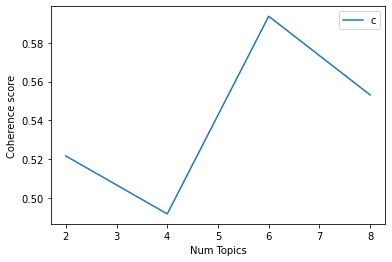

In [15]:
timed_df, text_list = get_timed_data(dis, 'Date', '2017-06-01', '2019-06-01')
remove_list = ['disney','walt','says','stock','s','p','u','m','q','th','vs','dis']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=2, limit=10, step=2)

In [16]:
lda, vis = lda_graph(6)
lda.print_topics()

[(0,
  '0.047*"stocks" + 0.020*"biggest" + 0.019*"making" + 0.016*"business" + 0.016*"moves" + 0.016*"million" + 0.014*"premarket" + 0.012*"box" + 0.012*"office" + 0.010*"big"'),
 (1,
  '0.028*"investors" + 0.019*"important" + 0.018*"stories" + 0.018*"morning" + 0.012*"cramer" + 0.010*"according" + 0.010*"friday" + 0.009*"trump" + 0.009*"ceo" + 0.009*"climate"'),
 (2,
  '0.021*"dow" + 0.019*"lower" + 0.016*"ceo" + 0.016*"record" + 0.015*"new" + 0.013*"ceos" + 0.011*"day" + 0.010*"trump" + 0.010*"close" + 0.009*"ends"'),
 (3,
  '0.021*"netflix" + 0.015*"earnings" + 0.013*"week" + 0.013*"warner" + 0.011*"china" + 0.009*"fox" + 0.009*"ahead" + 0.009*"people" + 0.009*"year" + 0.008*"t"'),
 (4,
  '0.030*"wall" + 0.028*"street" + 0.016*"open" + 0.014*"stocks" + 0.013*"set" + 0.012*"tax" + 0.011*"market" + 0.011*"fed" + 0.011*"dow" + 0.010*"media"'),
 (5,
  '0.028*"fox" + 0.021*"media" + 0.019*"ceo" + 0.016*"billion" + 0.016*"deal" + 0.014*"netflix" + 0.011*"comcast" + 0.010*"sky" + 0.009*"co

In [17]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.129562  0.070467       1        1  22.862261
3     -0.151475  0.044610       2        1  18.825495
0      0.178119 -0.104673       3        1  16.833137
4     -0.036665 -0.162656       4        1  15.687641
1     -0.005510 -0.043006       5        1  14.173225
2      0.145093  0.195258       6        1  11.618241, topic_info=           Term        Freq       Total Category  logprob  loglift
289      stocks  148.000000  148.000000  Default  30.0000  30.0000
118        wall   66.000000   66.000000  Default  29.0000  29.0000
116      street   61.000000   61.000000  Default  28.0000  28.0000
48    investors   63.000000   63.000000  Default  27.0000  27.0000
222     biggest   48.000000   48.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
163         job   10.229475   18.787943   Topic6  -5.0704   1.5447
3565     turned    9.224812   15.600271   Topic6  -5.1737   1.6272
1519    futures   10.619476   27.590779   Topic6  -5.0330   1.1978
68      million   13.049388   54.977397   Topic6  -4.8269   0.7144
733      streak    8.876769   26.788356   Topic6  -5.2122   1.0481

[300 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2286      5  0.978578  according
621       3  0.952269       adds
33        2  0.878392      ahead
33        4  0.109799      ahead
372       3  0.952638   alphabet
...     ...       ...        ...
164       6  0.935992       work
93        1  0.208035       year
93        2  0.531646       year
93        5  0.138690       year
93        6  0.115575       year

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 1, 5, 2, 3])

In [18]:
dis_3 = get_topic(timed_df)
dis_3.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
586,Disney vs Netflix: Here's which stock would ha...,4/24/2019 4:05:28 PM,Markets|Mad Money with Jim Cramer|Earn|Save an...,https://www.cnbc.com/2019/04/24/would-investin...,Media giants Disney and Netflix have both prov...,disney vs netflix here's which stock would ha...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-04-24 16:05:28,3,"[netflix, earnings, week, warner, china, fox, ..."


In [19]:
dis_3.to_pickle("./Data/dis_1706_1906.pkl")

### 2019.6.1 - 2021.7.1

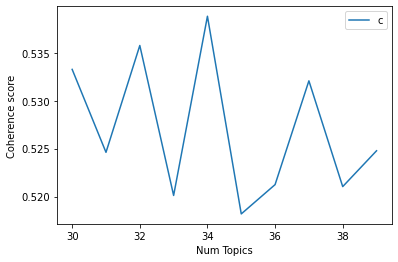

In [22]:
timed_df, text_list = get_timed_data(dis, 'Date', '2019-06-01', '2021-07-01')
remove_list = ['disney','walt','says','stock','s','p','u','m','q','th','vs','dis','t','j']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=30, limit=40, step=1)

In [23]:
lda, vis = lda_graph(34)
lda.print_topics()

[(27,
  '0.102*"new" + 0.071*"investors" + 0.050*"shows" + 0.048*"year" + 0.035*"movies" + 0.022*"power" + 0.019*"apple" + 0.018*"viacomcbs" + 0.016*"tiktok" + 0.015*"worker"'),
 (0,
  '0.032*"traders" + 0.027*"second" + 0.026*"ceo" + 0.025*"online" + 0.022*"amc" + 0.020*"netflix" + 0.019*"potential" + 0.019*"makes" + 0.016*"comeback" + 0.016*"value"'),
 (29,
  '0.058*"big" + 0.048*"coronavirus" + 0.035*"tech" + 0.034*"california" + 0.023*"future" + 0.022*"exclusive" + 0.020*"negative" + 0.020*"ceos" + 0.020*"tops" + 0.020*"tv"'),
 (19,
  '0.092*"wall" + 0.070*"street" + 0.055*"earnings" + 0.050*"netflix" + 0.043*"analysts" + 0.028*"analyst" + 0.025*"stocks" + 0.018*"trader" + 0.017*"major" + 0.017*"right"'),
 (5,
  '0.048*"sports" + 0.046*"trump" + 0.034*"house" + 0.026*"talks" + 0.025*"tax" + 0.024*"offer" + 0.022*"white" + 0.022*"marvel" + 0.022*"mean" + 0.022*"far"'),
 (20,
  '0.049*"best" + 0.044*"way" + 0.044*"investing" + 0.041*"streaming" + 0.038*"black" + 0.037*"services" + 0.

In [24]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26     0.016833 -0.282562       1        1  6.749636
18     0.282865  0.009288       2        1  4.739413
9     -0.022842 -0.237259       3        1  4.089014
2     -0.036079  0.099396       4        1  3.665959
19     0.001908 -0.134873       5        1  3.639795
1     -0.049212 -0.035156       6        1  3.540192
24    -0.083857 -0.018975       7        1  3.485912
16    -0.001417  0.046564       8        1  3.481090
33     0.018999 -0.014996       9        1  3.378629
14     0.013956 -0.074129      10        1  3.235588
21     0.173333  0.068767      11        1  3.143994
4      0.270297  0.073999      12        1  3.124198
7     -0.032336  0.045976      13        1  3.084916
32     0.045111 -0.004640      14        1  3.042806
0     -0.014061  0.017554      15        1  2.966276
27    -0.095755  0.092517      16        1  2.919191
13    -0.056730  0.040776      17        1  2.884636
12    -0.066963 -0.071025      18        1  2.855965
15    -0.063950  0.085214      19        1  2.711104
6     -0.031672  0.055466      20        1  2.686726
29    -0.057840  0.098949      21        1  2.663440
20    -0.054336  0.014642      22        1  2.628422
17     0.046775 -0.000944      23        1  2.445961
11    -0.050441  0.028834      24        1  2.276063
31    -0.027940  0.013934      25        1  2.247400
5      0.007089  0.001034      26        1  2.235210
30    -0.042353  0.050787      27        1  2.235069
10     0.056762 -0.027621      28        1  2.132968
3     -0.042785  0.012675      29        1  2.063319
28     0.030074 -0.041059      30        1  2.043634
25    -0.025000  0.089167      31        1  1.982118
8     -0.017295 -0.051084      32        1  1.957642
23    -0.024870  0.017744      33        1  1.874669
22    -0.066269  0.031039      34        1  1.789045, topic_info=             Term        Freq       Total Category  logprob  loglift
306         watch  131.000000  131.000000  Default  30.0000  30.0000
73         stocks  234.000000  234.000000  Default  29.0000  29.0000
25        biggest  175.000000  175.000000  Default  28.0000  28.0000
153        market  162.000000  162.000000  Default  27.0000  27.0000
747           dow  157.000000  157.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
546   coronavirus    5.535116  181.567777  Topic34  -4.0672   0.5330
1778    investing    2.091418   23.680798  Topic34  -5.0405   1.5967
410         money    2.323130   36.178544  Topic34  -4.9354   1.2779
29        netflix    3.513036  218.506244  Topic34  -4.5218  -0.1068
485          year    2.589414   71.197724  Topic34  -4.8269   0.7095

[1463 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1043     23  0.755121        able
3179     21  0.817322    abortion
2404     11  0.847102     academy
636      14  0.731137  accelerate
1315      6  0.785922   according
...     ...       ...         ...
695      19  0.723002        york
913      20  0.865621       young
2675      7  0.923105     youtube
794      30  0.748033     zealand
3534     19  0.739609        zone

[1826 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 19, 10, 3, 20, 2, 25, 17, 34, 15, 22, 5, 8, 33, 1, 28, 14, 13, 16, 7, 30, 21, 18, 12, 32, 6, 31, 11, 4, 29, 26, 9, 24, 23])

In [25]:
dis_4 = get_topic(timed_df)
dis_4.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
12,Disney delays test cruise over 'inconsistent' ...,6/28/2021 8:44:34 PM,Hotels Resorts and Cruise Lines,https://www.cnbc.com/2021/06/28/disney-delays-...,Disney Cruise Line is postponing its first tes...,disney delays test cruise over 'inconsistent' ...,{'negative': 1.0},0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2021-06-28 20:44:34,9,"[analyst, day, calls, biggest, apple, florida,..."


In [26]:
dis_4.to_pickle("./Data/dis_1906_2107.pkl")

# American Airlines

In [27]:
aal = pd.read_pickle("./Data/aal_cnbc_senti.pkl")
aal.head(1)

,Unnamed: 0,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy
0,0,Stocks making the biggest moves in the premark...,7/9/2021 1:49:28 PM,Market Insider,https://www.cnbc.com/2021/07/09/stocks-making-...,These are the stocks posting the largest moves...,stocks making the biggest moves in the premark...,"{'trust': 0.3333333333333333, 'positive': 0.33...",0.0,0.0,0.0,0.333333,0.0,0.333333,0.333333,0.0,0.0,0.0


### 2013 - 2015

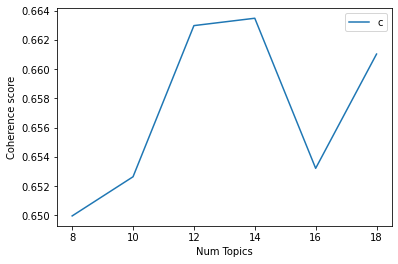

In [28]:
timed_df, text_list = get_timed_data(aal, 'Date', '2013-01-01', '2015-01-01')
remove_list = ['american airline','american airlines', 'stock','s','p','u','m','q','th','vs','dis','t','j']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=8, limit=20, step=2)

In [29]:
lda, vis = lda_graph(14)
lda.print_topics()

[(0,
  '0.035*"movers" + 0.024*"midday" + 0.011*"early" + 0.010*"new" + 0.008*"flight" + 0.008*"american" + 0.008*"airlines" + 0.005*"delta" + 0.005*"upgrades" + 0.005*"service"'),
 (1,
  '0.036*"airlines" + 0.031*"american" + 0.026*"airline" + 0.022*"stocks" + 0.012*"ceo" + 0.010*"flying" + 0.010*"new" + 0.010*"fees" + 0.009*"cramer" + 0.006*"lightning"'),
 (2,
  '0.018*"movers" + 0.016*"early" + 0.014*"round" + 0.014*"lightning" + 0.010*"stocks" + 0.010*"oil" + 0.009*"airline" + 0.008*"plane" + 0.008*"best" + 0.006*"missing"'),
 (3,
  '0.104*"movers" + 0.057*"midday" + 0.048*"early" + 0.014*"apple" + 0.011*"netflix" + 0.010*"ebay" + 0.009*"facebook" + 0.008*"airline" + 0.007*"exxon" + 0.007*"vz"'),
 (4,
  '0.018*"airlines" + 0.016*"flight" + 0.012*"american" + 0.012*"earnings" + 0.010*"delays" + 0.010*"air" + 0.008*"airways" + 0.008*"stocks" + 0.006*"travelers" + 0.006*"faa"'),
 (5,
  '0.023*"stocks" + 0.019*"merger" + 0.015*"amr" + 0.013*"air" + 0.013*"airways" + 0.012*"deal" + 0.01

In [30]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.249967 -0.027895       1        1  10.925370
2     -0.035599  0.044608       2        1   9.030244
4      0.084727 -0.037728       3        1   8.806948
1      0.049505  0.074746       4        1   8.636566
5      0.037437  0.144489       5        1   8.221695
8     -0.058299  0.070306       6        1   7.430011
0     -0.095349 -0.017151       7        1   6.766719
9      0.070641 -0.073790       8        1   6.680699
10     0.051569 -0.049301       9        1   6.209841
6      0.052889  0.019802      10        1   5.933717
12     0.033522 -0.072309      11        1   5.727847
11     0.015339  0.051220      12        1   5.395832
7      0.060154 -0.033792      13        1   5.155721
13    -0.016569 -0.093205      14        1   5.078790, topic_info=        Term       Freq      Total Category  logprob  loglift
472   movers  70.000000  70.000000  Default  30.0000  30.0000
603   midday  31.000000  31.000000  Default  29.0000  29.0000
469    early  39.000000  39.000000  Default  28.0000  28.0000
349    trade  10.000000  10.000000  Default  27.0000  27.0000
169   travel  16.000000  16.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
94       oil   0.660469  11.496150  Topic14  -5.7098   0.1233
110      air   0.660375  13.508431  Topic14  -5.7100  -0.0382
818   street   0.659564   7.529469  Topic14  -5.7112   0.5451
819     wall   0.659458   7.544086  Topic14  -5.7114   0.5430
1253     add   0.659333   1.914649  Topic14  -5.7116   1.9140

[815 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
584       2  0.370871   aal
584      14  0.370871   aal
468       1  0.305492  aapl
468       2  0.101831  aapl
468       5  0.203661  aapl
...     ...       ...   ...
519       4  0.250326  year
519       9  0.250326  year
519      11  0.250326  year
519      12  0.250326  year
801      12  0.518200  yhoo

[1234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 2, 6, 9, 1, 10, 11, 7, 13, 12, 8, 14])

In [31]:
aal_1 = get_topic(timed_df)
aal_1.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
537,American Airlines scraps paper manuals for tab...,9/11/2014 1:04:24 PM,Road Warrior,https://www.cnbc.com/2014/09/11/american-airli...,American Airlines has won regulatory approval ...,american airlines scraps paper manuals for tab...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-09-11 13:04:24,0,"[movers, midday, early, new, flight, american,..."


In [32]:
aal_1.to_pickle("./Data/aal_1301_1501.pkl")

### 2015 - 2019

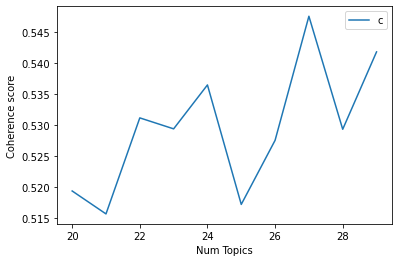

In [33]:
timed_df, text_list = get_timed_data(aal, 'Date', '2015-01-01', '2019-01-01')
remove_list = ['american airline','american airlines', 'stock','s','p','u','m','q','th','vs','t','j']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=20, limit=30, step=1)

In [34]:
lda, vis = lda_graph(26)
lda.print_topics()

[(20,
  '0.022*"airlines" + 0.017*"best" + 0.014*"cards" + 0.013*"new" + 0.012*"business" + 0.011*"companies" + 0.011*"united" + 0.008*"american" + 0.008*"delta" + 0.007*"rules"'),
 (25,
  '0.077*"movers" + 0.065*"early" + 0.022*"amzn" + 0.018*"aapl" + 0.015*"ibm" + 0.013*"midday" + 0.013*"aal" + 0.012*"dis" + 0.010*"tsla" + 0.009*"bac"'),
 (16,
  '0.030*"airlines" + 0.028*"flights" + 0.017*"cancel" + 0.015*"winter" + 0.015*"storm" + 0.013*"stocks" + 0.011*"ahead" + 0.011*"important" + 0.009*"stories" + 0.009*"morning"'),
 (7,
  '0.033*"travel" + 0.032*"hurricane" + 0.032*"airlines" + 0.030*"irma" + 0.011*"business" + 0.009*"korea" + 0.009*"north" + 0.009*"buys" + 0.008*"florida" + 0.008*"united"'),
 (11,
  '0.046*"trade" + 0.025*"week" + 0.024*"stocks" + 0.012*"rally" + 0.012*"oil" + 0.011*"china" + 0.011*"says" + 0.010*"wednesday" + 0.009*"travel" + 0.008*"thanksgiving"'),
 (10,
  '0.023*"script" + 0.023*"cctv" + 0.011*"airlines" + 0.011*"stocks" + 0.009*"flights" + 0.007*"trump" + 0

In [35]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22    -0.177317  0.159250       1        1  6.858336
15    -0.036302 -0.152546       2        1  5.701953
19    -0.012017 -0.171405       3        1  5.032694
2      0.012174 -0.095896       4        1  4.631975
11    -0.055424 -0.059731       5        1  4.203586
18    -0.045395 -0.104642       6        1  4.010920
12     0.144393  0.007214       7        1  4.000311
25     0.200192  0.025883       8        1  3.942922
16     0.076858  0.060005       9        1  3.918861
0     -0.009886  0.027078      10        1  3.882640
7     -0.035531  0.126255      11        1  3.863578
8     -0.059979  0.063084      12        1  3.794119
5     -0.009747 -0.040601      13        1  3.644578
9     -0.029414 -0.016224      14        1  3.641732
1     -0.090597  0.032832      15        1  3.633047
20    -0.028636  0.027803      16        1  3.624347
21     0.122433  0.051748      17        1  3.572807
14     0.146278  0.051021      18        1  3.519487
13     0.023219  0.020235      19        1  3.484523
17    -0.055135 -0.030530      20        1  3.345317
24    -0.013224 -0.054726      21        1  3.243766
4     -0.018302  0.039502      22        1  3.238516
6     -0.021162 -0.014952      23        1  3.162701
3     -0.059874  0.035295      24        1  3.108006
10     0.018546 -0.000711      25        1  2.964116
23     0.013852  0.014759      26        1  1.975163, topic_info=           Term        Freq       Total Category  logprob  loglift
148        wall   62.000000   62.000000  Default  30.0000  30.0000
147      street   61.000000   61.000000  Default  29.0000  29.0000
1      american  124.000000  124.000000  Default  28.0000  28.0000
992      movers   61.000000   61.000000  Default  27.0000  27.0000
1373      early   56.000000   56.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
983   lightning    0.706175   11.236664  Topic26  -5.7132   1.1574
984       round    0.706120   11.236671  Topic26  -5.7132   1.1574
1321       tops    0.705665    4.398857  Topic26  -5.7139   2.0946
1530     social    0.705665    5.198384  Topic26  -5.7139   1.9276
293       media    0.705665    6.686688  Topic26  -5.7139   1.6758

[1646 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
728       7  0.069642   aal
728       8  0.174104   aal
728       9  0.034821   aal
728      10  0.139283   aal
728      14  0.034821   aal
...     ...       ...   ...
2011     18  0.265786   yum
1397      9  0.225373  zika
1397     11  0.225373  zika
1397     22  0.225373  zika
1397     26  0.225373  zika

[3146 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 16, 20, 3, 12, 19, 13, 26, 17, 1, 8, 9, 6, 10, 2, 21, 22, 15, 14, 18, 25, 5, 7, 4, 11, 24])

In [36]:
aal_2 = get_topic(timed_df)
aal_2.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
244,Surging fuel and plunging stock: American Airl...,10/25/2018 12:35:32 AM,Airlines,https://www.cnbc.com/2018/10/24/american-airli...,The pressure is on American Airlines CEO as th...,surging fuel and plunging stock american airl...,{'anger': 1.0},0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-10-25 00:35:32,22,"[american, airlines, ceo, qatar, airways, prof..."


In [37]:
aal_2.to_pickle("./Data/aal_1501_1901.pkl")

### 2019 - 2020

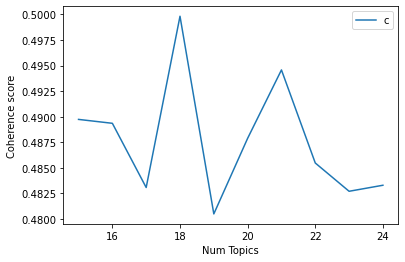

In [39]:
timed_df, text_list = get_timed_data(aal, 'Date', '2019-01-01', '2020-01-01')
remove_list = ['american airline','american airlines', 'stock','s','p','u','m','q','th','vs','t','j']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=15, limit=25, step=1)

In [40]:
lda, vis = lda_graph(18)
lda.print_topics()

[(0,
  '0.018*"dow" + 0.018*"airlines" + 0.013*"american" + 0.009*"day" + 0.009*"watch" + 0.009*"today" + 0.009*"travel" + 0.009*"ice" + 0.009*"earnings" + 0.009*"industry"'),
 (1,
  '0.022*"says" + 0.021*"airlines" + 0.017*"stocks" + 0.017*"american" + 0.013*"venezuela" + 0.009*"delta" + 0.009*"set" + 0.009*"data" + 0.009*"care" + 0.009*"trade"'),
 (2,
  '0.022*"max" + 0.018*"boeing" + 0.017*"new" + 0.014*"buy" + 0.013*"flights" + 0.011*"says" + 0.010*"airbus" + 0.010*"jet" + 0.010*"travel" + 0.008*"faa"'),
 (3,
  '0.064*"boeing" + 0.032*"max" + 0.029*"faa" + 0.021*"planes" + 0.020*"says" + 0.014*"airbus" + 0.014*"year" + 0.011*"citing" + 0.011*"analyst" + 0.010*"rally"'),
 (4,
  '0.024*"airline" + 0.023*"stocks" + 0.017*"earnings" + 0.014*"says" + 0.013*"boeing" + 0.013*"max" + 0.012*"season" + 0.010*"delta" + 0.010*"week" + 0.009*"change"'),
 (5,
  '0.068*"credit" + 0.051*"cards" + 0.043*"best" + 0.027*"july" + 0.014*"fee" + 0.013*"airline" + 0.010*"annual" + 0.008*"max" + 0.008*"so

In [41]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.284456  0.163396       1        1  9.428267
8     -0.109166 -0.118465       2        1  7.678990
17     0.110837  0.065016       3        1  6.925101
4     -0.029752  0.012399       4        1  6.578821
10     0.052160  0.032091       5        1  6.418711
14     0.094582  0.076912       6        1  6.157584
7      0.096862  0.072130       7        1  6.056257
16     0.045059 -0.036500       8        1  5.929538
15     0.024384  0.039291       9        1  5.921456
12     0.059983  0.028952      10        1  5.339724
9     -0.027114 -0.113703      11        1  4.754870
11     0.002697 -0.048343      12        1  4.754567
3      0.050646  0.040440      13        1  4.421568
2      0.022997 -0.037861      14        1  4.396065
5     -0.013722 -0.113488      15        1  4.366401
6     -0.000480  0.008582      16        1  4.296778
1     -0.026187 -0.020178      17        1  3.306279
0     -0.069328 -0.050669      18        1  3.269026, topic_info=           Term       Freq      Total Category  logprob  loglift
171      making  38.000000  38.000000  Default  30.0000  30.0000
172       moves  36.000000  36.000000  Default  29.0000  29.0000
174      stocks  58.000000  58.000000  Default  28.0000  28.0000
169     biggest  46.000000  46.000000  Default  27.0000  27.0000
277      credit  16.000000  16.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
527       risks   0.694235   2.117153  Topic18  -5.3824   2.3057
72         cuts   0.694235   6.530156  Topic18  -5.3824   1.1793
151      prices   0.694235   2.124461  Topic18  -5.3824   2.3022
234  government   0.694235   5.882215  Topic18  -5.3824   1.2838
279      enters   0.694235   2.172149  Topic18  -5.3824   2.2800

[1037 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
780      10  0.691668   ability
1126      6  0.677350    abroad
713       4  0.677100  absences
713       8  0.338550  absences
75       17  0.725178   accused
...     ...       ...       ...
632      11  0.276085     years
632      16  0.276085     years
915       3  0.674458    yields
1626     11  0.691666     young
434       1  0.660258       yum

[1566 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 9, 18, 5, 11, 15, 8, 17, 16, 13, 10, 12, 4, 3, 6, 7, 2, 1])

In [42]:
aal_3 = get_topic(timed_df)
aal_3.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
125,"Poor morale, sliding stock: Pressure mounts on...",10/9/2019 12:30:55 PM,Airlines,https://www.cnbc.com/2019/10/09/pressure-mount...,The airline's latest woes have added to chatte...,poor morale sliding stock pressure mounts on...,{'negative': 1.0},0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2019-10-09 12:30:55,6,"[boeing, max, airlines, stocks, flights, ameri..."


In [43]:
aal_3.to_pickle("./Data/aal_1901_2001.pkl")

### 2020 - 2021

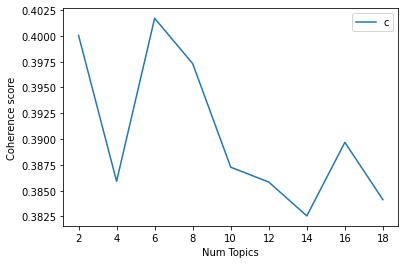

In [45]:
timed_df, text_list = get_timed_data(aal, 'Date', '2020-01-01', '2021-07-01')
remove_list = ['american airline','american airlines', 'stock','s','p','u','m','q','th','vs','t','j']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=2, limit=20, step=2)

In [46]:
lda, vis = lda_graph(6)
lda.print_topics()

[(0,
  '0.035*"coronavirus" + 0.027*"airlines" + 0.019*"american" + 0.014*"says" + 0.013*"flights" + 0.012*"trump" + 0.007*"ceo" + 0.006*"airline" + 0.006*"billion" + 0.006*"united"'),
 (1,
  '0.025*"coronavirus" + 0.019*"credit" + 0.016*"card" + 0.012*"says" + 0.011*"travel" + 0.009*"pandemic" + 0.008*"cards" + 0.008*"rewards" + 0.007*"new" + 0.007*"airline"'),
 (2,
  '0.059*"biggest" + 0.051*"stocks" + 0.051*"making" + 0.050*"moves" + 0.029*"midday" + 0.020*"airlines" + 0.018*"boeing" + 0.017*"premarket" + 0.016*"american" + 0.011*"tesla"'),
 (3,
  '0.034*"coronavirus" + 0.031*"airlines" + 0.019*"travel" + 0.018*"american" + 0.016*"says" + 0.013*"stocks" + 0.011*"airline" + 0.010*"cases" + 0.010*"demand" + 0.009*"new"'),
 (4,
  '0.066*"market" + 0.037*"dow" + 0.027*"live" + 0.016*"know" + 0.016*"things" + 0.016*"stocks" + 0.015*"points" + 0.014*"opens" + 0.012*"wednesday" + 0.011*"monday"'),
 (5,
  '0.035*"watch" + 0.031*"today" + 0.021*"dow" + 0.017*"set" + 0.013*"stocks" + 0.012*"d

In [47]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.006785  0.036639       1        1  21.999733
2     -0.235773 -0.098590       2        1  16.399223
4      0.153260 -0.176259       3        1  16.334174
5      0.052460  0.025132       4        1  16.312325
0     -0.006958  0.114000       5        1  14.852483
1      0.030226  0.099078       6        1  14.102062, topic_info=          Term        Freq       Total Category  logprob  loglift
225     market  167.000000  167.000000  Default  30.0000  30.0000
71     biggest  148.000000  148.000000  Default  29.0000  29.0000
73      making  123.000000  123.000000  Default  28.0000  28.0000
74       moves  122.000000  122.000000  Default  27.0000  27.0000
1240       dow  145.000000  145.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
422   outbreak    7.179835   18.919742   Topic6  -5.6656   0.9899
211      covid    8.551924   43.654685   Topic6  -5.4907   0.3287
0     airlines   11.922488  240.765676   Topic6  -5.1585  -1.0465
76      stocks   11.461893  248.704336   Topic6  -5.1979  -1.1184
4      flights    8.094304   57.762478   Topic6  -5.5457  -0.0063

[395 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
52        1  0.134482             add
52        3  0.134482             add
52        4  0.672412             add
1526      5  0.810990  administration
1087      5  0.912379             age
...     ...       ...             ...
590       5  0.129895           worst
1181      4  0.151978           worth
1181      5  0.759890           worth
2278      3  0.911226           young
2026      4  0.909794            zone

[704 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 6, 1, 2])

In [48]:
aal_4 = get_topic(timed_df)
aal_4.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
3,American Airlines cancels hundreds of flights ...,6/21/2021 2:56:35 AM,Airlines,https://www.cnbc.com/2021/06/21/american-airli...,American Airlines says it will trim its schedu...,american airlines cancels hundreds of flights ...,"{'anger': 0.3333333333333333, 'trust': 0.33333...",0.0,0.333333,0.0,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,2021-06-21 02:56:35,0,"[coronavirus, airlines, american, says, flight..."


In [49]:
aal_4.to_pickle("./Data/aal_2001_2107.pkl")

# PepsiCo

In [50]:
pep = pd.read_pickle("./Data/pep_cnbc_senti.pkl")
pep.head(1)

,Unnamed: 0,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy
0,0,Watch CNBC's full interview with PepsiCo CFO o...,4/15/2021 2:23:07 PM,Squawk Box U.S.,https://www.cnbc.com/video/2021/04/15/pepsico-...,PepsiCo on Thursday reported quarterly earning...,watch cnbc's full interview with pepsico cfo o...,"{'fear': 0.3333333333333333, 'positive': 0.333...",0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0


### 2010 - 2011.6

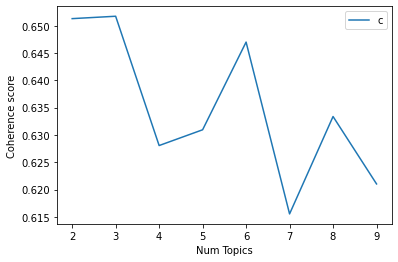

In [51]:
timed_df, text_list = get_timed_data(pep, 'Date', '2010-01-01', '2011-06-01')
remove_list = ['pep','pepsico','pepsi','stock','s','p','u','m','q','th','vs','t','j']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=2, limit=10, step=1)

In [52]:
lda, vis = lda_graph(3)
lda.print_topics()

[(0,
  '0.014*"strategist" + 0.012*"growth" + 0.012*"super" + 0.012*"stocks" + 0.010*"tech" + 0.009*"bowl" + 0.009*"futures" + 0.009*"news" + 0.009*"cramer" + 0.008*"market"'),
 (1,
  '0.017*"jobs" + 0.013*"earnings" + 0.012*"week" + 0.012*"market" + 0.011*"markets" + 0.011*"watch" + 0.010*"futures" + 0.010*"halftime" + 0.008*"companies" + 0.008*"pros"'),
 (2,
  '0.077*"stocks" + 0.023*"earnings" + 0.014*"dow" + 0.013*"ahead" + 0.013*"led" + 0.013*"close" + 0.011*"end" + 0.011*"rise" + 0.008*"week" + 0.008*"rises"')]

In [53]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.138171  0.005162       1        1  43.785511
0      0.063268 -0.094526       2        1  29.196640
1      0.074904  0.089364       3        1  27.017849, topic_info=           Term       Freq      Total Category  logprob  loglift
18       stocks  48.000000  48.000000  Default  30.0000  30.0000
115        jobs   7.000000   7.000000  Default  29.0000  29.0000
152  strategist   5.000000   5.000000  Default  28.0000  28.0000
162      growth   5.000000   5.000000  Default  27.0000  27.0000
71          dow   8.000000   8.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
235        year   1.530323   3.918367   Topic3  -5.4444   0.3685
56          big   1.528919   3.986326   Topic3  -5.4453   0.3504
160      cramer   1.540612   5.141243   Topic3  -5.4377   0.1036
333         day   1.499342   2.638345   Topic3  -5.4648   0.7435
292       slide   1.489352   3.345910   Topic3  -5.4715   0.4993

[175 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
217       1  0.646712        ad
217       2  0.161678        ad
47        2  0.621705       ads
47        3  0.310852       ads
360       1  0.303565   advance
...     ...       ...       ...
598       2  0.754964     woods
515       2  0.514262  wrangler
235       1  0.255208      year
235       2  0.255208      year
235       3  0.510417      year

[193 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [54]:
pep_1 = get_topic(timed_df)
pep_1.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
183,PepsiCo Unveils 100% Plant-Based Bottle,3/15/2011 1:11:19 PM,Companies,https://www.cnbc.com/id/42085382,PepsiCo on Tuesday unveiled a bottle made enti...,pepsico unveils plant-based bottle,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011-03-15 13:11:19,1,"[jobs, earnings, week, market, markets, watch,..."


In [55]:
pep_1.to_pickle("./Data/pep_1001_1106.pkl")

### 2011.6 - 2013.6

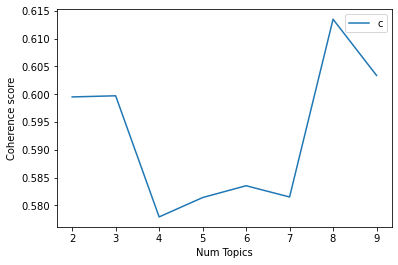

In [56]:
timed_df, text_list = get_timed_data(pep, 'Date', '2011-06-01', '2013-06-01')
remove_list = ['pep','pepsico','pepsi','stock','s','p','u','m','q','th','vs','t','j']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=2, limit=10, step=1)

In [57]:
lda, vis = lda_graph(8)
lda.print_topics()

[(0,
  '0.027*"stocks" + 0.018*"early" + 0.018*"movers" + 0.013*"soda" + 0.012*"watch" + 0.012*"industry" + 0.009*"machines" + 0.009*"calories" + 0.009*"record" + 0.009*"inflation"'),
 (1,
  '0.041*"stocks" + 0.015*"analysts" + 0.015*"week" + 0.012*"ahead" + 0.012*"debt" + 0.012*"gain" + 0.009*"market" + 0.009*"talks" + 0.009*"watch" + 0.009*"amid"'),
 (2,
  '0.039*"futures" + 0.028*"stocks" + 0.022*"report" + 0.020*"deal" + 0.020*"gain" + 0.014*"led" + 0.011*"gains" + 0.011*"cramer" + 0.011*"retail" + 0.011*"mixed"'),
 (3,
  '0.048*"stocks" + 0.016*"earnings" + 0.013*"pros" + 0.013*"almighty" + 0.013*"multiple" + 0.010*"commodities" + 0.009*"ahead" + 0.007*"news" + 0.007*"look" + 0.007*"week"'),
 (4,
  '0.059*"stocks" + 0.036*"lower" + 0.035*"futures" + 0.025*"end" + 0.020*"eu" + 0.019*"cramer" + 0.019*"earnings" + 0.014*"higher" + 0.013*"time" + 0.013*"sells"'),
 (5,
  '0.016*"stocks" + 0.016*"market" + 0.016*"consumer" + 0.012*"earnings" + 0.012*"staples" + 0.010*"logs" + 0.009*"dow

In [58]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.081361 -0.142229       1        1  15.251826
4     -0.140011  0.027167       2        1  14.997074
2     -0.062111  0.017919       3        1  13.970741
1      0.006353  0.116696       4        1  12.949500
0      0.123462 -0.079835       5        1  12.661460
3      0.009097  0.019461       6        1  11.781055
6      0.051186  0.036236       7        1   9.212875
5      0.093385  0.004585       8        1   9.175470, topic_info=        Term       Freq      Total Category  logprob  loglift
155  futures  24.000000  24.000000  Default  30.0000  30.0000
369    lower  10.000000  10.000000  Default  29.0000  29.0000
273      end  16.000000  16.000000  Default  28.0000  28.0000
39    report   6.000000   6.000000  Default  27.0000  27.0000
1        new   8.000000   8.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
790  highest   0.698028   1.957058   Topic8  -5.4535   1.3577
459     star   0.698025   2.642174   Topic8  -5.4535   1.0575
511     ways   0.698025   1.953808   Topic8  -5.4535   1.3594
144     game   0.698024   1.985996   Topic8  -5.4535   1.3430
634      bac   0.698020   1.970651   Topic8  -5.4536   1.3508

[447 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
378       5  0.499580         aapl
435       3  0.740627  accelerates
158       3  0.311349           ad
158       7  0.311349           ad
158       8  0.311349           ad
...     ...       ...          ...
445       1  0.370079         year
445       5  0.370079         year
313       6  0.757407          yeo
429       1  0.484012        young
430       1  0.484012          yum

[596 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 3, 2, 1, 4, 7, 6])

In [60]:
pep_2 = get_topic(timed_df)
pep_2.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
158,"PepsiCo profit dips; more ads, new products on...",10/17/2012 6:14:00 AM,Wires,https://www.cnbc.com/id/100181823,NEW YORK-- PepsiCo Inc.' s net income dipped 5...,pepsico profit dips; more ads new products on...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-10-17 06:14:00,6,"[new, earnings, stocks, profit, futures, turna..."


In [61]:
pep_2.to_pickle("./Data/pep_1106_1306.pkl")

### 2013.6 - 2015.6

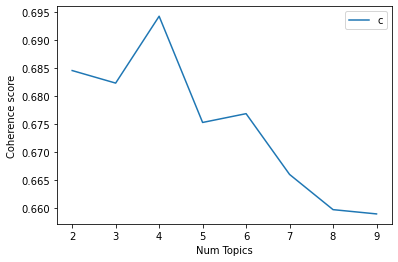

In [62]:
timed_df, text_list = get_timed_data(pep, 'Date', '2013-06-01', '2015-06-01')
remove_list = ['pep','pepsico','pepsi','stock','s','p','u','m','q','th','vs','t','j']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=2, limit=10, step=1)

In [63]:
lda, vis = lda_graph(4)
lda.print_topics()

[(0,
  '0.015*"stocks" + 0.013*"ceo" + 0.011*"trade" + 0.010*"futures" + 0.009*"earnings" + 0.006*"women" + 0.006*"higher" + 0.006*"oil" + 0.005*"data" + 0.005*"nfl"'),
 (1,
  '0.030*"stocks" + 0.016*"cramer" + 0.014*"close" + 0.012*"big" + 0.011*"round" + 0.011*"lightning" + 0.009*"coke" + 0.009*"dow" + 0.008*"says" + 0.008*"higher"'),
 (2,
  '0.017*"cramer" + 0.015*"earnings" + 0.013*"movers" + 0.012*"new" + 0.012*"stocks" + 0.008*"market" + 0.008*"coke" + 0.008*"peltz" + 0.007*"midday" + 0.007*"week"'),
 (3,
  '0.021*"early" + 0.020*"movers" + 0.013*"earnings" + 0.012*"soda" + 0.010*"board" + 0.007*"cramer" + 0.007*"profit" + 0.006*"dow" + 0.005*"super" + 0.005*"fisher"')]

In [64]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.110200  0.069408       1        1  28.960831
2     -0.071363 -0.012486       2        1  27.286754
0      0.037627 -0.113000       3        1  23.127483
3     -0.076464  0.056078       4        1  20.624931, topic_info=           Term       Freq      Total Category  logprob  loglift
322       early  11.000000  11.000000  Default  30.0000  30.0000
73       movers  15.000000  15.000000  Default  29.0000  29.0000
260       close   7.000000   7.000000  Default  28.0000  28.0000
202      stocks  28.000000  28.000000  Default  27.0000  27.0000
112         big   6.000000   6.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
328      record   1.398586   3.172036   Topic4  -5.5702   0.7598
34        sales   1.380883   5.101014   Topic4  -5.5830   0.2720
43   sodastream   1.380717   3.811675   Topic4  -5.5831   0.5632
254   companies   1.379635   6.416553   Topic4  -5.5839   0.0416
15        talks   1.376621   3.784107   Topic4  -5.5861   0.5675

[228 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
475       4  0.801245       aa
512       4  0.809070     aapl
330       4  0.537995    added
273       2  0.394318  advance
273       3  0.394318  advance
...     ...       ...      ...
305       1  0.396351    world
305       4  0.396351    world
160       2  0.515756    wrong
232       2  0.313807     year
232       3  0.313807     year

[281 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [66]:
pep_3 = get_topic(timed_df)
pep_3.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
138,"Peltz blasts PepsiCo again, seeks details on o...",3/14/2014 4:22:42 AM,Business,https://www.cnbc.com/2014/03/13/peltz-blasts-p...,"Nelson Peltz, who has been pushing PepsiCo to ...",peltz blasts pepsico again seeks details on o...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-03-14 04:22:42,1,"[stocks, cramer, close, big, round, lightning,..."


In [67]:
pep_3.to_pickle("./Data/pep_1306_1506.pkl")

### 2015.6 - 2018

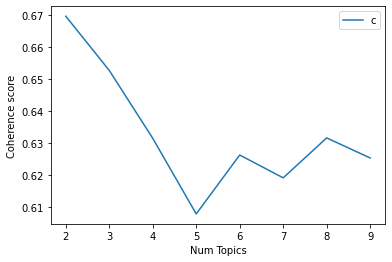

In [68]:
timed_df, text_list = get_timed_data(pep, 'Date', '2015-06-01', '2018-01-01')
remove_list = ['pep','pepsico','pepsi','stock','s','p','u','m','q','th','vs','t','j','f','k']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=2, limit=10, step=1)

In [69]:
lda, vis = lda_graph(2)
lda.print_topics()

[(0,
  '0.023*"stocks" + 0.021*"cramer" + 0.016*"earnings" + 0.008*"ceo" + 0.007*"remix" + 0.007*"new" + 0.006*"plan" + 0.006*"watch" + 0.005*"companies" + 0.005*"shares"'),
 (1,
  '0.015*"cramer" + 0.011*"early" + 0.011*"movers" + 0.010*"street" + 0.010*"wall" + 0.008*"market" + 0.007*"ceos" + 0.006*"cfo" + 0.005*"ceo" + 0.005*"trade"')]

In [70]:
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.085921  0.0       1        1  50.639769
0     -0.085921  0.0       2        1  49.360231, topic_info=         Term       Freq      Total Category  logprob  loglift
146    stocks  37.000000  37.000000  Default  30.0000  30.0000
110      wall  14.000000  14.000000  Default  29.0000  29.0000
24   earnings  25.000000  25.000000  Default  28.0000  28.0000
281     early  16.000000  16.000000  Default  27.0000  27.0000
283    movers  16.000000  16.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
245     rally   3.932584   7.336872   Topic2  -5.8695   0.0824
159     round   3.150724   3.992232   Topic2  -6.0912   0.4693
375       oil   3.837245  10.019443   Topic2  -5.8941  -0.2537
17      sales   3.681032   8.680094   Topic2  -5.9356  -0.1518
7    beverage   3.555075   8.010874   Topic2  -5.9704  -0.1064

[124 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
131       1  0.995248        ad
310       1  0.272980     ahead
310       2  0.682449     ahead
7         1  0.499321  beverage
7         2  0.499321  beverage
...     ...       ...       ...
93        2  0.926136     watch
188       1  0.250327      week
188       2  0.750982      week
130       2  1.003253     women
482       1  0.853174    yellen

[122 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [71]:
pep_4 = get_topic(timed_df)
pep_4.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
87,PepsiCo makes the biggest public pre-order of ...,12/12/2017 2:42:46 PM,Autos,https://www.cnbc.com/2017/12/12/pepsico-makes-...,PepsiCo has reserved 100 of Tesla's new electr...,pepsico makes the biggest public pre-order of ...,"{'positive': 0.5, 'anticipation': 0.5}",0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,2017-12-12 14:42:46,0,"[stocks, cramer, earnings, ceo, remix, new, pl..."


In [72]:
pep_4.to_pickle("./Data/pep_1506_1801.pkl")

### 2018 - 2019

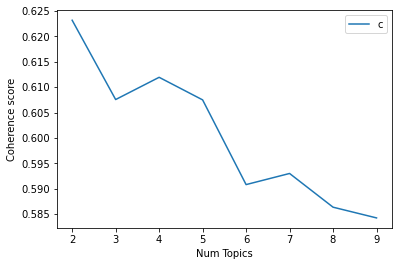

In [73]:
timed_df, text_list = get_timed_data(pep, 'Date', '2018-01-01', '2019-01-01')
remove_list = ['pep','pepsico','pepsi','stock','s','p','u','m','q','th','vs','t','j','f','k']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=2, limit=10, step=1)

In [74]:
lda, vis = lda_graph(2)
lda.print_topics()

[(0,
  '0.021*"earnings" + 0.019*"ceo" + 0.018*"indra" + 0.015*"nooyi" + 0.010*"cramer" + 0.010*"stocks" + 0.008*"market" + 0.007*"beverage" + 0.005*"bowl" + 0.005*"super"'),
 (1,
  '0.012*"stocks" + 0.009*"biggest" + 0.008*"consumer" + 0.008*"companies" + 0.007*"company" + 0.007*"staples" + 0.007*"says" + 0.006*"pay" + 0.006*"cramer" + 0.006*"women"')]

In [75]:
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.076053  0.0       1        1  54.309329
1     -0.076053  0.0       2        1  45.690671, topic_info=         Term       Freq      Total Category  logprob  loglift
7    earnings  13.000000  13.000000  Default  30.0000  30.0000
0         ceo  12.000000  12.000000  Default  29.0000  29.0000
46      nooyi  10.000000  10.000000  Default  28.0000  28.0000
44      indra  13.000000  13.000000  Default  27.0000  27.0000
132  consumer   4.000000   4.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
1      cramer   3.271317  10.036146   Topic2  -5.1216  -0.3377
216       new   2.730251   5.602523   Topic2  -5.3024   0.0645
51      years   2.171909   3.080991   Topic2  -5.5312   0.4336
125     trump   2.168388   3.718245   Topic2  -5.5328   0.2440
182     ahead   2.161367   5.629839   Topic2  -5.5361  -0.1741

[125 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
182       1  0.532875    ahead
182       2  0.355250    ahead
206       2  0.817584     amzn
146       2  1.087947    apple
12        1  0.946194     beat
...     ...       ...      ...
234       2  0.982150  winning
192       2  0.817833    women
161       1  0.789431     work
51        1  0.324571    years
51        2  0.649142    years

[114 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [76]:
pep_4 = get_topic(timed_df)
pep_4.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
58,Cramer: Outgoing PepsiCo CEO 'saw the future c...,8/7/2018 12:21:36 AM,Mad Money,https://www.cnbc.com/2018/08/06/cramer-outgoin...,Jim Cramer talks about his personal experience...,cramer outgoing pepsico ceo 'saw the future c...,{'anticipation': 1.0},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-08-07 00:21:36,0,"[earnings, ceo, indra, nooyi, cramer, stocks, ..."


In [77]:
pep_4.to_pickle("./Data/pep_1801_1901.pkl")

### 2019 - 2021

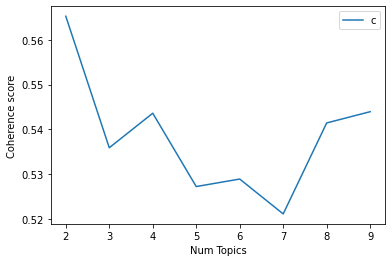

In [114]:
timed_df, text_list = get_timed_data(pep, 'Date', '2019-01-01', '2021-07-01')
remove_list = ['pep','pepsico','pepsi','stock','says','say','s','p','u','m','q','th','vs','t','j','f','k','e','company']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=2, limit=10, step=1)

In [115]:
lda, vis = lda_graph(2)
# lda.print_topics()

In [116]:
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.095293  0.0       1        1  55.201843
1     -0.095293  0.0       2        1  44.798157, topic_info=         Term       Freq      Total Category  logprob  loglift
76    biggest  28.000000  28.000000  Default  30.0000  30.0000
79      moves  23.000000  23.000000  Default  29.0000  29.0000
78     making  22.000000  22.000000  Default  28.0000  28.0000
43     cramer  33.000000  33.000000  Default  27.0000  27.0000
2    earnings  27.000000  27.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
5       watch   5.923816  15.181063   Topic2  -5.3500  -0.1381
50   consumer   4.462881   8.211488   Topic2  -5.6332   0.1933
114      food   3.734628   6.136850   Topic2  -5.8114   0.3063
354      tech   3.569659   5.440921   Topic2  -5.8565   0.3815
351       big   3.699758   9.664467   Topic2  -5.8207  -0.1572

[123 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
339       1  0.949607    ahead
339       2  0.118701    ahead
285       2  0.932694  america
118       2  0.994903  analyst
93        1  0.294272    apple
...     ...       ...      ...
154       2  0.850006     want
5         1  0.592844    watch
5         2  0.395229    watch
345       1  1.002705     week
55        1  0.904810    years

[123 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [128]:
for i in pep_5.clean_data:
    if 'pfizer' in i:
        print(i)

stocks making the biggest moves midday  pfizer  apple  moderna  tesla  pepsico   more
stocks making the biggest moves in the premarket  pepsico  analog devices  carnival  pfizer   more
stocks making the biggest moves in the premarket  m  caterpillar  pfizer  pepsico  merck   more
stocks making the biggest moves premarket  pfizer  mylan  blackrock  blackstone  domino's   more
stocks making the biggest moves in the premarket  regeneron  pfizer  boeing  amazon   more


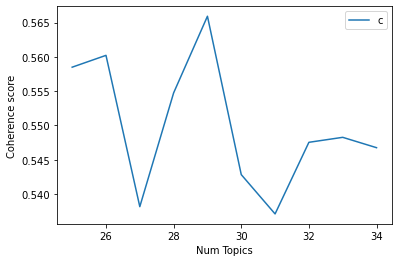

In [121]:
timed_df, text_list = get_timed_data(pep, 'Date', '2019-01-01', '2021-07-01')
remove_list = ['pep','pepsico','pepsi','stock','says','say','s','p','u','m','q','th','vs','t','j','f','k','e','company']
texts, dictionary, corpus = get_arguments(text_list, remove_list)
get_score_graph(start=25, limit=35, step=1)

In [122]:
lda, vis = lda_graph(29)
# lda.print_topics()

In [123]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.329494  0.002001       1        1  9.314970
4     -0.049948  0.190139       2        1  5.994461
15     0.018960  0.102202       3        1  4.908117
17     0.005610  0.174776       4        1  4.711798
8      0.012406  0.015302       5        1  4.596602
1     -0.035436 -0.103209       6        1  4.520630
13     0.059549  0.059928       7        1  3.909917
11     0.062188 -0.009711       8        1  3.898017
27     0.037537  0.085721       9        1  3.832229
3     -0.062995  0.002196      10        1  3.753102
6      0.063190  0.006944      11        1  3.681437
28     0.010222 -0.044677      12        1  3.606978
21    -0.228223 -0.064161      13        1  3.453928
23     0.024172 -0.026422      14        1  3.240483
7      0.034561 -0.004327      15        1  3.039546
14     0.020275 -0.058027      16        1  2.803930
26    -0.005243  0.022205      17        1  2.801091
19     0.002495  0.013905      18        1  2.744683
10     0.038348 -0.036763      19        1  2.634365
5      0.052439 -0.016109      20        1  2.621730
0      0.059133 -0.056282      21        1  2.614252
12     0.036292 -0.004885      22        1  2.611690
24     0.032435 -0.062107      23        1  2.560277
20     0.003174  0.037600      24        1  2.483885
18     0.020356 -0.048765      25        1  2.340155
22     0.042770 -0.070983      26        1  2.092634
9     -0.010378 -0.017487      27        1  2.013077
25     0.031079 -0.047922      28        1  1.748673
16     0.054526 -0.041085      29        1  1.467342, topic_info=               Term      Freq      Total Category  logprob  loglift
78           making  27.00000  27.000000  Default  30.0000  30.0000
79            moves  28.00000  28.000000  Default  29.0000  29.0000
76          biggest  33.00000  33.000000  Default  28.0000  28.0000
46           stocks  58.00000  58.000000  Default  27.0000  27.0000
80        premarket  19.00000  19.000000  Default  26.0000  26.0000
...             ...       ...        ...      ...      ...      ...
2          earnings   0.82643  26.803574  Topic29  -3.9009   0.7425
549   entertainment   0.01806   1.237787  Topic29  -7.7244  -0.0057
1080        couples   0.01806   1.237812  Topic29  -7.7244  -0.0057
0              beat   0.01806   7.351967  Topic29  -7.7244  -1.7873
3         interview   0.01806   2.061548  Topic29  -7.7244  -0.5158

[1391 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1098      8  0.730721      aaron
499       2  0.696179         ab
1160     25  0.770416   academic
500       2  0.243225  according
500       5  0.243225  according
...     ...       ...        ...
647      10  0.368528        yum
647      16  0.368528        yum
1113     14  0.751106       zero
959      11  0.725915       zone
801      22  0.764884      zones

[1754 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 16, 18, 9, 2, 14, 12, 28, 4, 7, 29, 22, 24, 8, 15, 27, 20, 11, 6, 1, 13, 25, 21, 19, 23, 10, 26, 17])

In [85]:
pep_5 = get_topic(timed_df)
pep_5.head(1)

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words
0,Watch CNBC's full interview with PepsiCo CFO o...,4/15/2021 2:23:07 PM,Squawk Box U.S.,https://www.cnbc.com/video/2021/04/15/pepsico-...,PepsiCo on Thursday reported quarterly earning...,watch cnbc's full interview with pepsico cfo o...,"{'fear': 0.3333333333333333, 'positive': 0.333...",0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,2021-04-15 14:23:07,1,"[earnings, watch, beat, stocks, trade, set, to..."


In [86]:
pep_5.to_pickle("c")

In [90]:
pep_5.to_csv('pep_cnbc_1901_2107.csv')

In [95]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
pep_5['compound_sent'] = pep_5.apply(lambda x: sia.polarity_scores(x.clean_data)['compound'], axis=1)

In [94]:
# nltk.download('vader_lexicon')

In [96]:
pep_5

,Title,Date,Section,Url,Summary,clean_data,sentimental_raw,fear,anger,anticip,...,surprise,positive,negative,sadness,disgust,joy,date,topic,topic_words,compound_sent
0,Watch CNBC's full interview with PepsiCo CFO o...,4/15/2021 2:23:07 PM,Squawk Box U.S.,https://www.cnbc.com/video/2021/04/15/pepsico-...,PepsiCo on Thursday reported quarterly earning...,watch cnbc's full interview with pepsico cfo o...,"{'fear': 0.3333333333333333, 'positive': 0.333...",0.333333,0.0,0.0,...,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,2021-04-15 14:23:07,1,"[earnings, watch, beat, stocks, trade, set, to...",0.0000
1,"PepsiCo CFO Hugh Johnston on Q1 results, growt...",4/15/2021 2:12:35 PM,Squawk Box U.S.,https://www.cnbc.com/video/2021/04/15/pepsico-...,PepsiCo on Thursday reported quarterly earning...,pepsico cfo hugh johnston on q results growth...,"{'positive': 0.3333333333333333, 'negative': 0...",0.000000,0.0,0.0,...,0.000000,0.333333,0.333333,0.000000,0.0,0.000000,2021-04-15 14:12:35,15,"[cramer, jim, money, buying, earnings, cfo, bi...",0.3818
2,"UBS upgrades PepsiCo to buy, calling stock a '...",4/21/2021 12:39:54 PM,Pro: Street Calls,https://www.cnbc.com/2021/04/21/ubs-upgrades-p...,The investment firm raised its outlook on the ...,ubs upgrades pepsico to buy calling stock a '...,{'trust': 0.375},0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2021-04-21 12:39:54,21,"[cramer, stocks, market, beverage, ceos, buy, ...",0.0000
3,Rockstar Energy sales growth returns after Pep...,4/15/2021 3:24:01 PM,Food and Beverage,https://www.cnbc.com/2021/04/15/rockstar-energ...,Rockstar Energy sales are growing again after ...,rockstar energy sales growth returns after pep...,{'positive': 1.0},0.000000,0.0,0.0,...,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,2021-04-15 15:24:01,14,"[boost, returns, energy, pandemic, week, amazo...",0.5719
4,PepsiCo revenue rises 6.8% despite unbalanced ...,4/15/2021 12:10:19 PM,Food and Beverage,https://www.cnbc.com/2021/04/15/pepsico-pep-q1...,PepsiCo on Thursday reported quarterly earning...,pepsico revenue rises despite unbalanced ec...,{'positive': 1.0},0.000000,0.0,0.0,...,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,2021-04-15 12:10:19,17,"[biggest, stocks, making, moves, premarket, mi...",0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2590,The number of women running Fortune 500 compan...,5/16/2019 6:30:44 PM,Closing The Gap|Work|Make It,https://www.cnbc.com/2019/05/16/the-number-of-...,"In the latest Fortune 500 list, published toda...",the number of women running fortune companies...,"{'trust': 0.2, 'surprise': 0.2, 'positive': 0....",0.000000,0.0,0.0,...,0.200000,0.200000,0.000000,0.000000,0.0,0.200000,2019-05-16 18:30:44,6,"[energy, rockstar, ceo, billion, says, maker, ...",0.0772
2591,"7 foods, grocery items and other essentials to...",3/15/2019 5:34:24 PM,Make It|Spend|Money,https://www.cnbc.com/2019/03/15/7-foods-grocer...,"To get the most out of your Walmart shopping, ...",foods grocery items and other essentials to a...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2019-03-15 17:34:24,16,"[cramer, opens, know, market, things, jim, inv...",0.0000
2592,"Coke vs. Pepsi: If you invested $1,000 10 year...",2/27/2019 8:53:41 PM,Make It|Make It - Guide|CNBC Digital Original ...,https://www.cnbc.com/video/2019/02/27/coca-col...,"Whether you're team Coke or team Pepsi, here's...",coke vs pepsi if you invested years ago ...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2019-02-27 20:53:41,8,"[years, ago, invested, stocks, cfo, food, name...",0.0000
2593,This is how much it costs to air a commercial ...,1/30/2019 7:42:21 PM,Power Players|Money|Make It,https://www.cnbc.com/2019/01/30/how-much-it-co...,"Year after year, huge brands like Budweiser an...",this is how much it costs to air 

In [99]:
len(pep_5[pep_5.compound_sent == 0])

175

In [102]:
pep_5.to_csv('pep_cnbc_1901_2107_updated.csv')